In [1]:
"""
This experiment uses hashprint with delta features that won't change weights.
"""

"\nThis experiment uses hashprint with delta features that won't change weights.\n"

In [2]:
# Set the experiment name to be something meaningful. 
# It will be part of the name of the model to be saved.
EXPERIMENT_NAME = "[HashNet-100-iteration-dropout-delta-notrain]"
DEBUG = True        # Set to True if you want to see outputs used for debugging 
verbose = False      # Set to True if you want to see the loss function per epoch in real time

In [3]:
from IPython.display import SVG

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers.core import Activation, Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Input, Concatenate, Layer, GaussianNoise, BatchNormalization
from keras.applications import vgg19
from keras.utils import plot_model
from keras.optimizers import RMSprop, Adam
from keras import backend as K
from keras.utils.vis_utils import model_to_dot

import sys
import datetime
import keras
import pickle
import logging
import h5py
import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy import ndimage
import scipy.io

from songdb import data_dict
from preprocess import preprocess
from model import build_model

%matplotlib inline

/home/mjenrungrot/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/mjenrungrot/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
logger = logging.getLogger()

# File Handler
fhandler = logging.FileHandler(filename='{:}.log'.format(EXPERIMENT_NAME), mode='w')
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)

# Output stream Handler
ch = logging.StreamHandler(sys.stdout)
ch.setFormatter(formatter)
logger.addHandler(ch)

if DEBUG: 
    logger.setLevel(logging.DEBUG)
    ch.setLevel(logging.DEBUG)
else:     
    logger.setLeveL(logging.INFO)
    ch.setLevel(logging.INFO)

## Config Keras

In this code, we will use tensorflow backend on Keras because it's relatively faster than Theano. We'll use the image data format in the form of `(n_channel, width, height)`. Please look at the Keras documentation for more details.

In [5]:
assert K.backend() == 'tensorflow'
logger.debug("Keras backend is tensorflow.")

K.set_image_data_format('channels_first')
assert K.image_data_format() == 'channels_first'
logger.debug("Keras image data format is channels_first")

2018-03-08 21:39:00,617 - root - DEBUG - Keras backend is tensorflow.
2018-03-08 21:39:00,619 - root - DEBUG - Keras image data format is channels_first


## Load dataset
We load the pair-annotation dataset. Here, we generate an array of of shapes `(n_pairs, 2, 76, 121)`.

In [6]:
logger.debug("Load Paired-annotation data")
data = data_dict()
logger.debug("\t data.type = {:}".format(type(data)))
logger.debug("\t data = {:}".format(data))
ref_query_pairs = data['taylorswift']

songPairs = []
totalPairs = 0 
for ref, query in ref_query_pairs:
    # Get pairs for each ref + query
    curr_pairs = []
    for i in range(ref.shape[0]):
        refQ = preprocess(librosa.cqt(np.asfarray(ref[i], dtype='float32'), sr = 22050, fmin=130.81, n_bins=121, bins_per_octave=24, hop_length=96), 3).T
        queryQ = preprocess(librosa.cqt(np.asfarray(query[i], dtype='float32'), sr = 22050, fmin=130.81, n_bins=121, bins_per_octave=24, hop_length=96), 3).T
        Q_pair = np.append(np.array([refQ]), np.array([queryQ]), axis=0)[np.newaxis, :]
        curr_pairs.append(Q_pair)
    curr_pairs = np.vstack(tuple(curr_pairs))
    totalPairs += curr_pairs.shape[0]
    songPairs.append(curr_pairs)
    logger.debug("Song {:}: Finish current pairs with shape = {:}".format(len(songPairs), curr_pairs.shape))
    logger.debug("Number of samples for the current song: {:}".format(len(curr_pairs)))

logger.debug("There are {:} number of pairs".format(totalPairs))

2018-03-08 21:39:00,668 - root - DEBUG - Load Paired-annotation data
2018-03-08 21:39:00,669 - root - DEBUG - 	 data.type = <class 'dict'>
2018-03-08 21:39:00,671 - root - DEBUG - 	 data = {'taylorswift': <generator object get_ref_query_pairs at 0x7ff2b0233ba0>}


/home/mjenrungrot/anaconda3/lib/python3.6/site-packages/librosa/util/utils.py:1725: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(x.dtype, float) or np.issubdtype(x.dtype, complex):
/home/mjenrungrot/anaconda3/lib/python3.6/site-packages/librosa/util/utils.py:1725: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(x.dtype, float) or np.issubdtype(x.dtype, complex):
/home/mjenrungrot/anaconda3/lib/python3.6/site-packages/librosa/util/utils.py:1725: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(x.dtype, float) or np.issubdtype(x.d

2018-03-08 21:39:22,430 - root - DEBUG - Song 1: Finish current pairs with shape = (272, 2, 76, 121)
2018-03-08 21:39:22,433 - root - DEBUG - Number of samples for the current song: 272
2018-03-08 21:39:42,548 - root - DEBUG - Song 2: Finish current pairs with shape = (264, 2, 76, 121)
2018-03-08 21:39:42,550 - root - DEBUG - Number of samples for the current song: 264
2018-03-08 21:39:50,877 - root - DEBUG - Song 3: Finish current pairs with shape = (100, 2, 76, 121)
2018-03-08 21:39:50,878 - root - DEBUG - Number of samples for the current song: 100
2018-03-08 21:39:58,354 - root - DEBUG - Song 4: Finish current pairs with shape = (100, 2, 76, 121)
2018-03-08 21:39:58,356 - root - DEBUG - Number of samples for the current song: 100
2018-03-08 21:40:15,987 - root - DEBUG - Song 5: Finish current pairs with shape = (221, 2, 76, 121)
2018-03-08 21:40:15,989 - root - DEBUG - Number of samples for the current song: 221
2018-03-08 21:40:35,631 - root - DEBUG - Song 6: Finish current pairs 

In [7]:
p_train = .6
cutOffIdx = 0
currentNumberOfPairs = 0
for song in songPairs:
    currentNumberOfPairs += song.shape[0]
    cutOffIdx += 1
    if currentNumberOfPairs >= totalPairs * p_train:
        break

data_train = tuple(songPairs[:cutOffIdx])
data_val = tuple(songPairs[cutOffIdx:])
logger.debug("Finish loading paired-annotation data")
logger.debug("=> There are {:} songs for training [{:.2f} percent]".format(len(data_train), (currentNumberOfPairs/totalPairs * 100.0)))
logger.debug("=> There are {:} songs for validation".format(len(data_val)))

2018-03-08 21:45:34,442 - root - DEBUG - Finish loading paired-annotation data
2018-03-08 21:45:34,443 - root - DEBUG - => There are 14 songs for training [63.52 percent]
2018-03-08 21:45:34,444 - root - DEBUG - => There are 6 songs for validation


## Preprocessing
Obtain a matrix $X_1$, $X_2$, $[w_{ij}]$, and $[s_{ij}]$ where $X_1$ and $X_2$ are pairs of images of shape 
`(n_samples, 1, width, height)`; $[w_{ij}]$ is the weight vector of shape `(n_samples, 1)` which describes the weight of each pair; and $[s_{ij}]$ is a binary vector of shape `(n_samples,1)` indicating whether inputs $i$ and $j$ are the same.

__Add similar pairs__

We add similar pairs based on the dataset we have.

__Add non-similar pairs__

We add non-similar pairs by randomly selecting two CQT frames from the dataset. Note that we say two CQT pairs are not similar when they come from different songs only.

__Data Post-processing__

Convert $X_1$, $X_2$, $[s_{ij}]$ in to numpy arrays.

__Calculate weights__

Calculate the weight vector $[w_{ij}]$. The term $w_{ij}$ is defined as 

$$
    w_{ij} = \begin{cases}
    \frac{|S|}{|S_{1}|} &\text{if $x^{(i)}$ is similar to $x^{(j)}$}\\
    \frac{|S|}{|S_{0}|} &\text{if $x^{(i)}$ is not similar to $x^{(j)}$}
    \end{cases}
$$

In [8]:
def generate_training_data(data, nNonSimilar=1000):
#     nPairs = data.shape[0] 
    X1 = []
    X2 = []
    S = []
    groundTruth = []
    
    # add similar pairs
    for songId in range(len(data)):
        nPairs = data[songId].shape[0]
        for idx in range(nPairs):
            X1.append(np.expand_dims(data[songId][idx][0][:][:], axis=0))
            X2.append(np.expand_dims(data[songId][idx][1][:][:], axis=0))
            groundTruth.append(((songId,idx),(songId,idx)))
            S.append(True)
        
    # add non-similar pairs
    for i in range(nNonSimilar):
        [songId1, songId2] = np.random.choice(len(data), 2, replace=False)
        nPairs1 = data[songId1].shape[0]
        nPairs2 = data[songId2].shape[0]

        [idx1] = np.random.choice(nPairs1, 1)
        [idx2] = np.random.choice(nPairs2, 1)
        X1.append(np.expand_dims(data[songId1][idx1][0][:][:], axis=0))
        X2.append(np.expand_dims(data[songId2][idx2][1][:][:], axis=0))
        S.append((songId1,idx1) == (songId2,idx2))
        groundTruth.append(((songId1,idx1),(songId2,idx2)))
        
    # post-processing
    X1 = np.array(X1)
    X2 = np.array(X2)
    S = np.array(S).reshape(-1,1)
    # calculate weights
    n_sim = len(S[S==True])
    w_sim   = len(X1) / n_sim             # w_ij for similar pairs
    w_insim = len(X1) / (len(X1) - n_sim)  # w_ij for dissimilar pairs
    W = S*w_sim + (~S)*w_insim          # w vector for pairs
    S = S.astype('float32')
    
    logger.debug("X1 shape: {:}".format(X1.shape))
    logger.debug("X2 shape: {:}".format(X2.shape))
    logger.debug("S shape: {:}".format(S.shape))
    logger.debug("W shape: {:}".format(W.shape))
    logger.debug("There are {:} out of {:} pairs that are similar [{:.2f} percent]".format(n_sim, 
                                                                                           len(X1),
                                                                                           100.0*n_sim/len(X1)))
    
    return X1, X2, S, W, groundTruth

In [9]:
X1, X2, S, W, groundTruth = generate_training_data(data_train)
X1_val, X2_val, S_val, W_val, groundTruth_val = generate_training_data(data_val)

2018-03-08 21:45:34,910 - root - DEBUG - X1 shape: (4237, 1, 76, 121)
2018-03-08 21:45:34,911 - root - DEBUG - X2 shape: (4237, 1, 76, 121)
2018-03-08 21:45:34,912 - root - DEBUG - S shape: (4237, 1)
2018-03-08 21:45:34,913 - root - DEBUG - W shape: (4237, 1)
2018-03-08 21:45:34,914 - root - DEBUG - There are 3237 out of 4237 pairs that are similar [76.40 percent]
2018-03-08 21:45:35,143 - root - DEBUG - X1 shape: (2859, 1, 76, 121)
2018-03-08 21:45:35,144 - root - DEBUG - X2 shape: (2859, 1, 76, 121)
2018-03-08 21:45:35,145 - root - DEBUG - S shape: (2859, 1)
2018-03-08 21:45:35,145 - root - DEBUG - W shape: (2859, 1)
2018-03-08 21:45:35,146 - root - DEBUG - There are 1859 out of 2859 pairs that are similar [65.02 percent]


In [10]:
nPairs = X1.shape[0]

## Model

__Define inputs__

Create a HashNet model with four inputs: two images tensors, similarity vector, and weight vector.

In [11]:
width = 76
height = 121
n_channel = 1

In [12]:
image_a    = Input(shape=(n_channel, width, height), name='image_1')
image_b    = Input(shape=(n_channel, width, height), name='image_2')
similarity = Input(shape=(1,), name="similarity")
weight     = Input(shape=(1,), name="weight")

__Pre-trained model__

Use a pre-trained model here to obtain intermediate values from the pre-trained model. We call this pre-trained model by `base_model`. The `base_model` is generally used to convert a CQT image to some representation.

In [13]:
model_path = '/data1/mint/public/taylorswift_out/model.mat'
model = scipy.io.loadmat(model_path)
logger.debug("Load model from {:}".format(model_path))
evecs = np.array(model['eigvecs']).T

2018-03-08 21:45:35,547 - root - DEBUG - Load model from /data1/mint/public/taylorswift_out/model.mat


In [14]:
m = 20
pca_matrix = np.array([vec.reshape((m, -1)) for vec in evecs])
delta = 4
base_model = build_model(pca_matrix, refQ.shape, delta=delta, compute_delta=True)
logger.debug("Construct base model")

2018-03-08 21:45:39,429 - root - DEBUG - Construct base model


In [15]:
# pop last layer
lastLayer = base_model.layers[-1]
base_model.pop()

# add dropout
base_model.add(Dropout(0.8)) # Drop 80%

# add batch normalization 
lastLayer.trainable = False
base_model.add(lastLayer)

2018-03-08 21:45:39,824 - root - DEBUG - Save base_model architecture to base_model.png


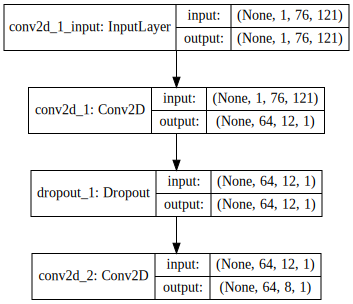

In [16]:
plot_model(base_model, show_shapes=True, to_file='base_model.png')
logger.debug("Save base_model architecture to base_model.png")
SVG(model_to_dot(base_model, show_shapes=True).create(prog='dot', format='svg'))

__Obtain intermediate values__

Intermediate values are values directly after the base model.

In [17]:
# Obtain intermediate tensor
intermediate_a = base_model(image_a)
intermediate_b = base_model(image_b)

# Flatten the layer
flatten_a = Flatten()(intermediate_a)
flatten_b = Flatten()(intermediate_b)

__Append a layer for binary encoding__

This layer has a `tanh` activation defined in the same way as HashNet paper. Note that initial beta value, number of bits, and `alpha` in the block below are hyperparameters.

In [18]:
beta         = 1            # Initial beta value
numberOfBits = None
alpha        = 0.05         # Set to be something small because it prevents the loss function from blowing up.
logger.debug("[HashNet Model] beta = {:}, numberOfBits = {:}, alpha = {:}".format(beta, numberOfBits, alpha))

2018-03-08 21:45:40,111 - root - DEBUG - [HashNet Model] beta = 1, numberOfBits = None, alpha = 0.05


In [19]:
def custom_activation(x):
    """
    Our own defined activation function
    """
    global beta
    return K.tanh(beta * x)

In [20]:
class CustomizedLossLayer(Layer):
    """
    Our own defined layer for keeping track of loss function
    """
    
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomizedLossLayer, self).__init__(**kwargs)
    
    def my_loss(self, encoded_a, encoded_b, similarity, weight):
        global alpha
        x = encoded_a
        y = encoded_b
        dot_product = K.sum(x * y, axis=-1, keepdims=True)
        logger.debug(dot_product)
        return K.sum(weight * (K.log(1 + K.exp(alpha * dot_product)) - alpha * similarity * dot_product))
    
    def call(self, inputs):
        encoded_a = inputs[0]
        encoded_b = inputs[1]
        similarity = inputs[2]
        weight = inputs[3]
        loss = self.my_loss(encoded_a, encoded_b, similarity, weight)
        self.add_loss(loss, inputs=inputs)
        return K.ones_like(similarity)


In [21]:
activation_layer = Activation(custom_activation)
encoded_a = activation_layer(flatten_a)
encoded_b = activation_layer(flatten_b)

__Create a model for training__

We construct a model using 2 representations derived by the same base model and similarity and weight. The architecture of the model is given below.

In [22]:
# Define a loss layer with 4 inputs
loss = CustomizedLossLayer()([encoded_a, encoded_b, similarity, weight])

2018-03-08 21:45:40,180 - root - DEBUG - Tensor("customized_loss_layer_1/Sum:0", shape=(?, 1), dtype=float32)


In [23]:
# Define a model that has 4 inputs and outputs loss
model = Model(inputs=[image_a, image_b, similarity, weight], outputs=[loss])

In [24]:
# Compile the model with our own defined loss function.
# Note that loss function is already defined in a layer, so
# `zero_loss` here doesn't actually do anything.

def zero_loss(y_true, y_pred):
    return K.zeros_like(y_pred)

logger.debug("Use Adam optimizer with lr = 1e-4")
adam = Adam(lr=1e-4)
model.compile(optimizer=adam, loss=zero_loss)

2018-03-08 21:45:40,212 - root - DEBUG - Use Adam optimizer with lr = 1e-4


__Visualize model architecture__

2018-03-08 21:45:40,477 - root - DEBUG - Save model architecture to model.png


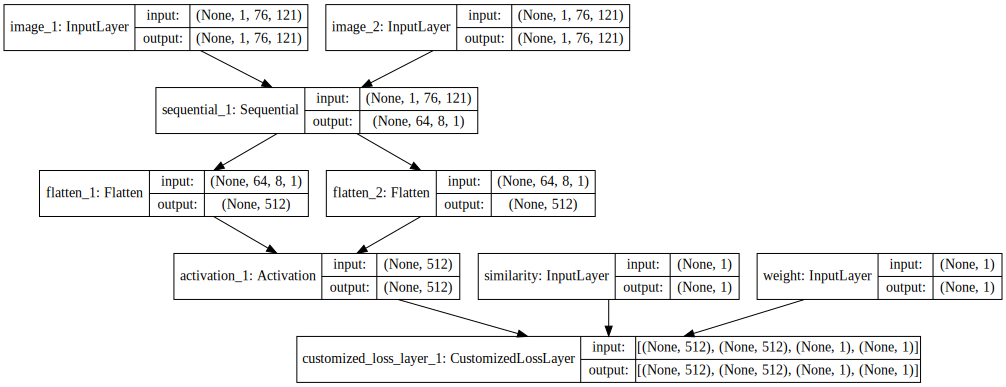

In [25]:
plot_model(model, show_shapes=True, to_file='model.png')
logger.debug("Save model architecture to model.png")
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## Visualize performance before training

For the purpose of understanding the performance of this algorithm, we find the baseline result by computing the hamming distance between two representations before training and then plotting the corresponding histogram. Based on the above diagram, we use the representation at layers named `flatten_1` and `flatten_2`, before the fully connected layer defined by HashNet paper.

In [26]:
representation_model = Model(image_a, flatten_a)

In [27]:
def visualize(X1, X2, groundTruth, model):
    plt.figure()
    hist_sim = []
    hist_non_sim = []
    bins = np.linspace(0, 400, 100)

    pred_X1 = (model.predict(X1) > 0)
    pred_X2 = (model.predict(X2) > 0)
    for idx in range(len(X1)):
        score = np.count_nonzero(pred_X1[idx] != pred_X2[idx])
        similarity = (groundTruth[idx][0] == groundTruth[idx][1])

        if similarity:
            hist_sim.append(score)
        else:
            hist_non_sim.append(score)

    plt.ylim((0, 135))
    plt.ylabel("Count")
    plt.xlabel("$|x-y|$, e.g. Hamming distance")
    plt.hist(hist_sim, bins, alpha=0.5, label='Similar pairs', color='blue')
    plt.hist(hist_non_sim, bins, alpha=0.5, label='Non-similar pairs', color='orange')
    plt.legend()
    plt.show()

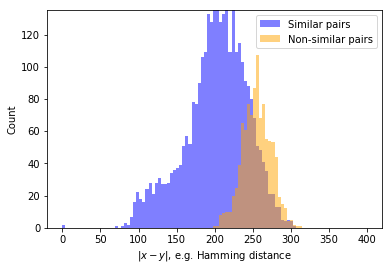

In [28]:
visualize(X1, X2, groundTruth, representation_model)

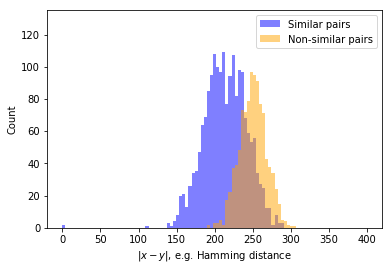

In [29]:
visualize(X1_val, X2_val, groundTruth_val, representation_model)

In [30]:
def visualizeFilters():
    nFilters = base_model.layers[0].get_weights()[0].shape[-1]
    plt.figure(figsize=(8,20))
    plt.tight_layout(pad=0, w_pad=0, h_pad=-10)
    for i in range(nFilters):
        filt = base_model.layers[0].get_weights()[0][:,:,0,i]
        plt.subplot(7, 10, i+1)
        plt.imshow(filt.T, cmap='jet')
        plt.xticks([])
        plt.yticks([])
    plt.show()

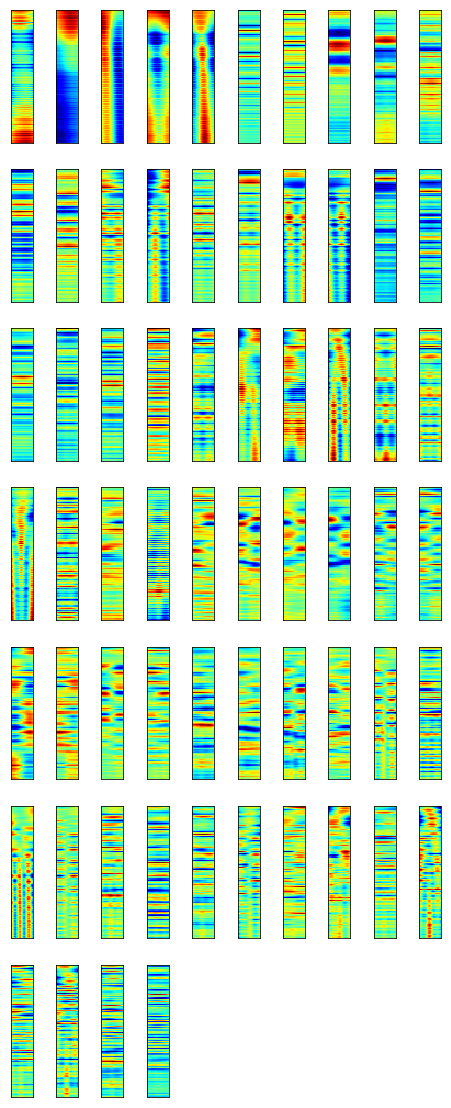

In [31]:
visualizeFilters()

## Train a model

In [32]:
# Check the input shape
logger.debug("Ready to train the model")
logger.debug("X1 shape: {:}".format(X1.shape))
logger.debug("X2 shape: {:}".format(X2.shape))
logger.debug("S shape: {:}".format(S.shape))
logger.debug("W shape: {:}".format(W.shape))

2018-03-08 21:45:47,052 - root - DEBUG - Ready to train the model
2018-03-08 21:45:47,053 - root - DEBUG - X1 shape: (4237, 1, 76, 121)
2018-03-08 21:45:47,054 - root - DEBUG - X2 shape: (4237, 1, 76, 121)
2018-03-08 21:45:47,055 - root - DEBUG - S shape: (4237, 1)
2018-03-08 21:45:47,056 - root - DEBUG - W shape: (4237, 1)


In [33]:
number_of_iterations = 30
logger.debug("[Training] number_of_iterations = {:}".format(number_of_iterations))
beta_factor = 1.5
logger.debug("[Training] beta_factor = {:}".format(beta_factor))
number_of_epochs = 200
logger.debug("[Training] number_of_epochs = {:}".format(number_of_epochs))

2018-03-08 21:45:47,071 - root - DEBUG - [Training] number_of_iterations = 30
2018-03-08 21:45:47,072 - root - DEBUG - [Training] beta_factor = 1.5
2018-03-08 21:45:47,073 - root - DEBUG - [Training] number_of_epochs = 200


In [34]:
train_losses = []
test_losses = []

2859/2859 [==============================] - 1s 208us/step
2018-03-08 21:45:48,525 - root - DEBUG - [Iteration = 0] Training Loss = 36.432179767104756, Testing Loss = 43.16924792747057
2018-03-08 21:45:48,529 - root - DEBUG - Iteration 1 (current beta = 1)


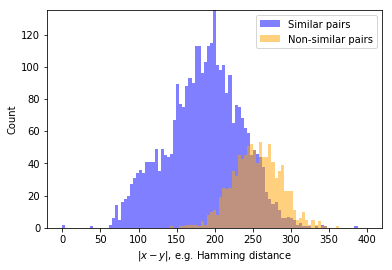

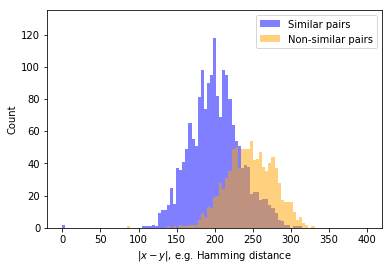

2859/2859 [==============================] - 1s 210us/step
2018-03-08 21:49:36,761 - root - DEBUG - [Iteration = 1] Training Loss = 52.232593137459205, Testing Loss = 63.741095198580915
2018-03-08 21:49:36,762 - root - DEBUG - Iteration 2 (current beta = 1.5)


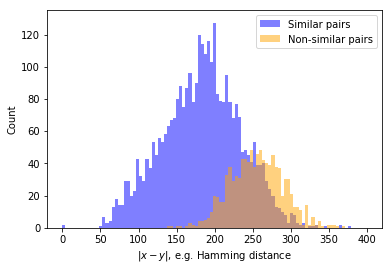

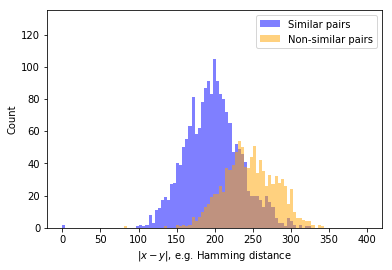

2859/2859 [==============================] - 1s 213us/step
2018-03-08 21:53:25,001 - root - DEBUG - [Iteration = 2] Training Loss = 56.211836863659954, Testing Loss = 70.07093803012818
2018-03-08 21:53:25,003 - root - DEBUG - Iteration 3 (current beta = 2.25)


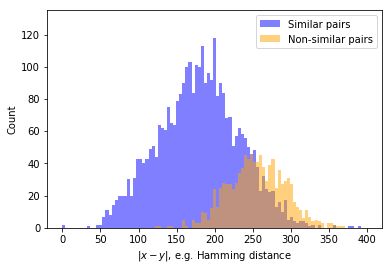

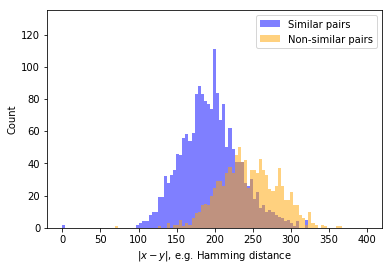

2859/2859 [==============================] - 1s 191us/step
2018-03-08 21:57:08,648 - root - DEBUG - [Iteration = 3] Training Loss = 61.147460945501415, Testing Loss = 77.67684387902189
2018-03-08 21:57:08,650 - root - DEBUG - Iteration 4 (current beta = 3.375)


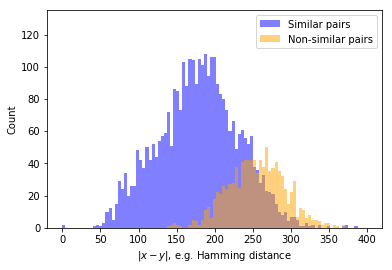

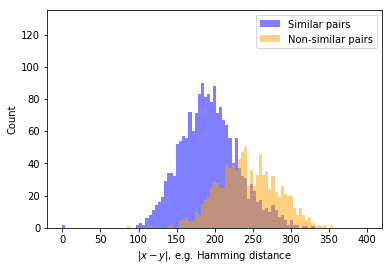

2859/2859 [==============================] - 1s 183us/step
2018-03-08 22:00:47,635 - root - DEBUG - [Iteration = 4] Training Loss = 59.98199598138621, Testing Loss = 80.85450324873776
2018-03-08 22:00:47,637 - root - DEBUG - Iteration 5 (current beta = 5.0625)


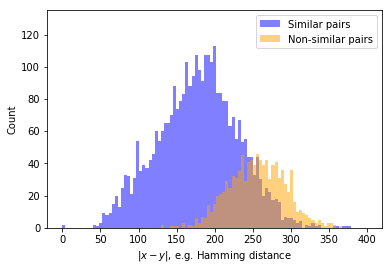

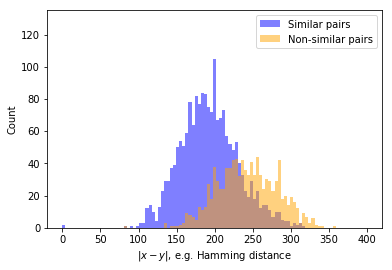

2859/2859 [==============================] - 1s 185us/step
2018-03-08 22:04:24,733 - root - DEBUG - [Iteration = 5] Training Loss = 58.798574307810576, Testing Loss = 82.07348929105333
2018-03-08 22:04:24,734 - root - DEBUG - Iteration 6 (current beta = 7.59375)


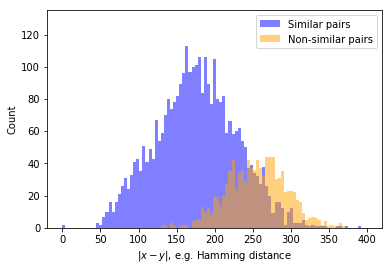

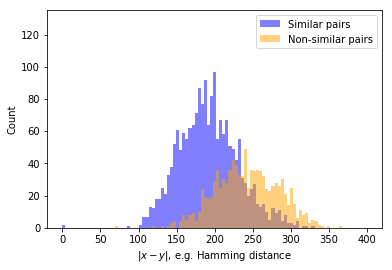

2859/2859 [==============================] - 1s 187us/step
2018-03-08 22:08:05,061 - root - DEBUG - [Iteration = 6] Training Loss = 62.459315404929406, Testing Loss = 84.9294816510333
2018-03-08 22:08:05,062 - root - DEBUG - Iteration 7 (current beta = 11.390625)


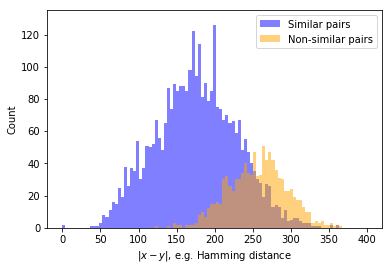

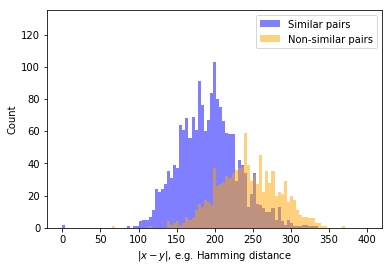

2859/2859 [==============================] - 1s 188us/step
2018-03-08 22:11:45,584 - root - DEBUG - [Iteration = 7] Training Loss = 60.43335170857367, Testing Loss = 82.47891194572729
2018-03-08 22:11:45,585 - root - DEBUG - Iteration 8 (current beta = 17.0859375)


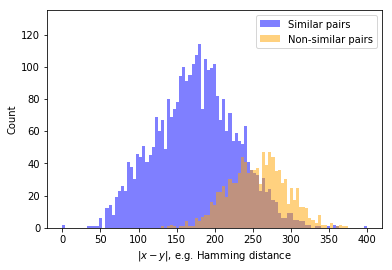

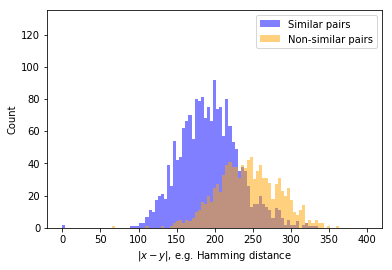

2859/2859 [==============================] - 1s 182us/step
2018-03-08 22:15:24,195 - root - DEBUG - [Iteration = 8] Training Loss = 59.60844408230672, Testing Loss = 81.75365381884633
2018-03-08 22:15:24,197 - root - DEBUG - Iteration 9 (current beta = 25.62890625)


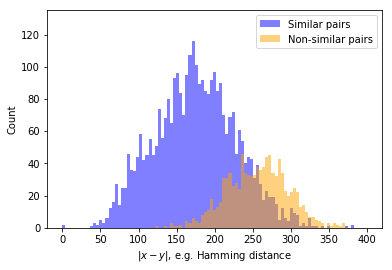

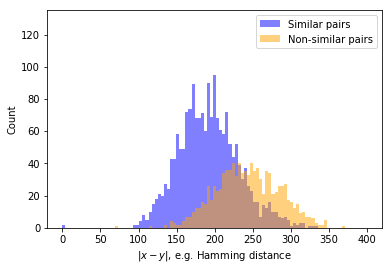

2859/2859 [==============================] - 1s 183us/step
2018-03-08 22:19:01,876 - root - DEBUG - [Iteration = 9] Training Loss = 61.71315177093821, Testing Loss = 85.36332713260897
2018-03-08 22:19:01,877 - root - DEBUG - Iteration 10 (current beta = 38.443359375)


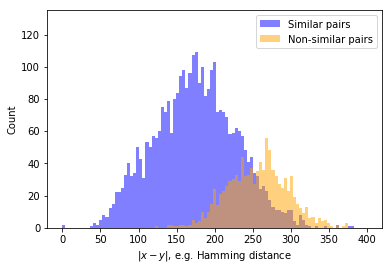

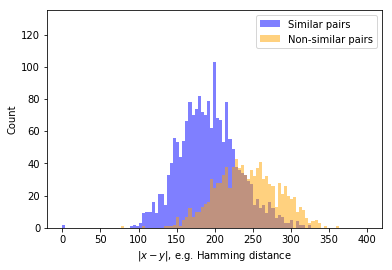

2859/2859 [==============================] - 1s 183us/step
2018-03-08 22:22:42,001 - root - DEBUG - [Iteration = 10] Training Loss = 61.61789948906468, Testing Loss = 85.3792226842418
2018-03-08 22:22:42,002 - root - DEBUG - Iteration 11 (current beta = 57.6650390625)


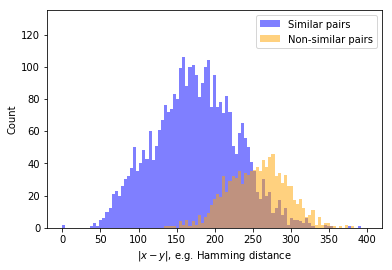

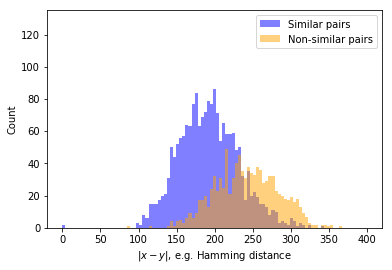

2859/2859 [==============================] - 1s 186us/step
2018-03-08 22:26:19,670 - root - DEBUG - [Iteration = 11] Training Loss = 60.79431622956807, Testing Loss = 85.84899163446296
2018-03-08 22:26:19,671 - root - DEBUG - Iteration 12 (current beta = 86.49755859375)


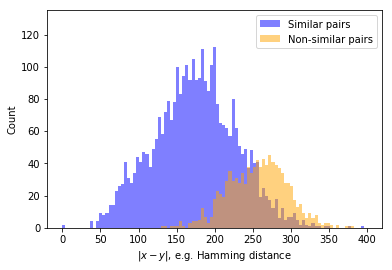

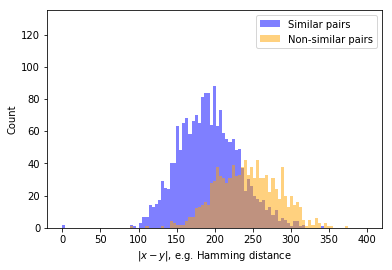

2859/2859 [==============================] - 1s 179us/step
2018-03-08 22:29:57,812 - root - DEBUG - [Iteration = 12] Training Loss = 58.99823445572914, Testing Loss = 84.25831491265859
2018-03-08 22:29:57,814 - root - DEBUG - Iteration 13 (current beta = 129.746337890625)


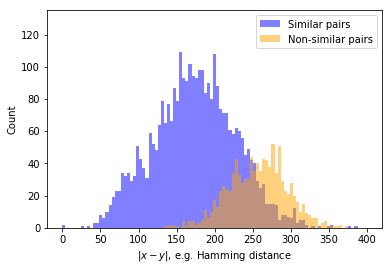

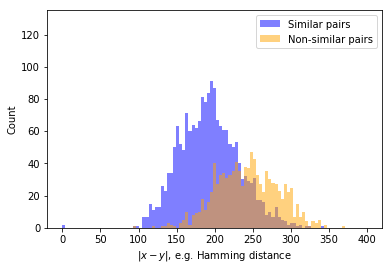

2859/2859 [==============================] - 1s 180us/step
2018-03-08 22:33:35,002 - root - DEBUG - [Iteration = 13] Training Loss = 57.747570783631375, Testing Loss = 84.45788201480197
2018-03-08 22:33:35,003 - root - DEBUG - Iteration 14 (current beta = 194.6195068359375)


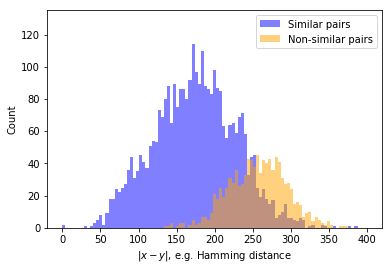

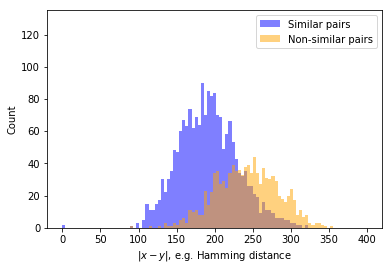

2859/2859 [==============================] - 1s 181us/step
2018-03-08 22:37:14,932 - root - DEBUG - [Iteration = 14] Training Loss = 58.10930437506202, Testing Loss = 85.44927497834082
2018-03-08 22:37:14,933 - root - DEBUG - Iteration 15 (current beta = 291.92926025390625)


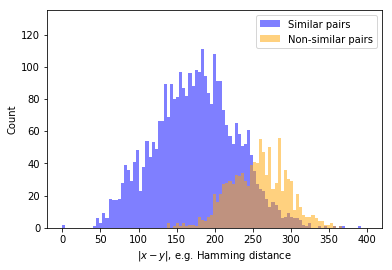

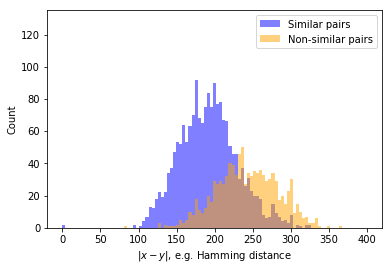

2859/2859 [==============================] - 1s 187us/step
2018-03-08 22:40:48,187 - root - DEBUG - [Iteration = 15] Training Loss = 56.87793782266006, Testing Loss = 84.03703784125382
2018-03-08 22:40:48,189 - root - DEBUG - Iteration 16 (current beta = 437.8938903808594)


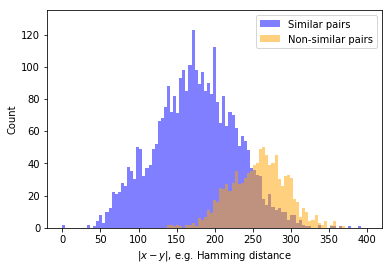

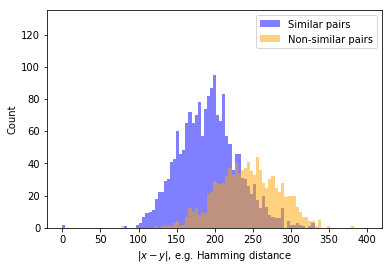

2859/2859 [==============================] - 1s 181us/step
2018-03-08 22:44:16,720 - root - DEBUG - [Iteration = 16] Training Loss = 56.87616924959388, Testing Loss = 82.76108639854866
2018-03-08 22:44:16,722 - root - DEBUG - Iteration 17 (current beta = 656.8408355712891)


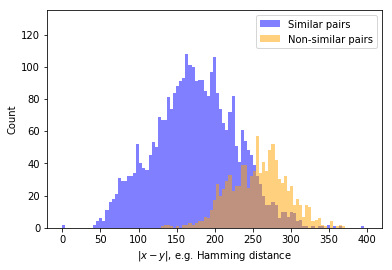

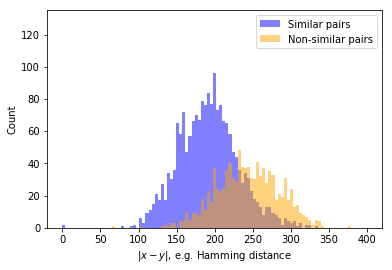

2859/2859 [==============================] - 1s 189us/step
2018-03-08 22:47:55,437 - root - DEBUG - [Iteration = 17] Training Loss = 57.965800495027395, Testing Loss = 83.34178728938895
2018-03-08 22:47:55,439 - root - DEBUG - Iteration 18 (current beta = 985.2612533569336)


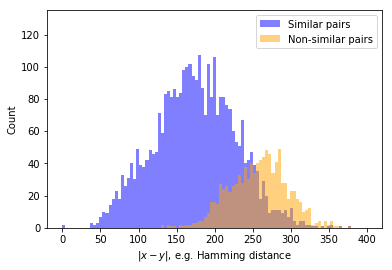

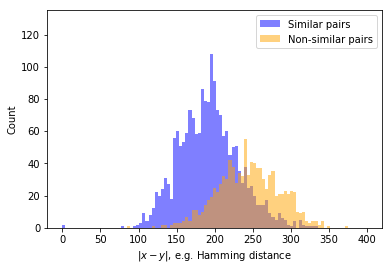

2859/2859 [==============================] - 1s 195us/step
2018-03-08 22:51:36,279 - root - DEBUG - [Iteration = 18] Training Loss = 57.23900971386748, Testing Loss = 81.12509412088357
2018-03-08 22:51:36,281 - root - DEBUG - Iteration 19 (current beta = 1477.8918800354004)


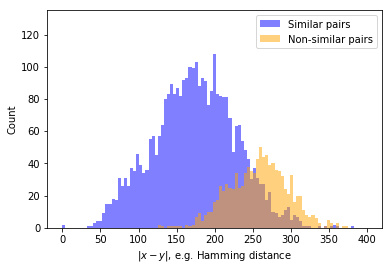

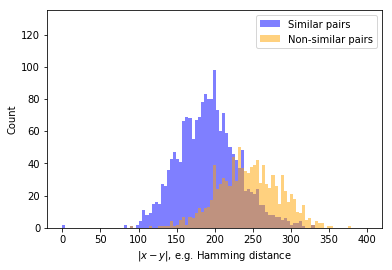

2859/2859 [==============================] - 1s 184us/step
2018-03-08 22:55:14,501 - root - DEBUG - [Iteration = 19] Training Loss = 58.12471684856713, Testing Loss = 81.34515076602577
2018-03-08 22:55:14,502 - root - DEBUG - Iteration 20 (current beta = 2216.8378200531006)


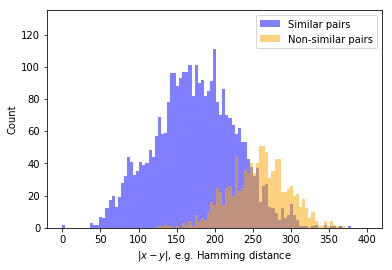

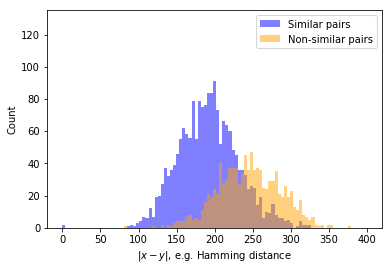

2859/2859 [==============================] - 1s 184us/step
2018-03-08 22:58:54,434 - root - DEBUG - [Iteration = 20] Training Loss = 58.21098744270697, Testing Loss = 80.88683450747386
2018-03-08 22:58:54,435 - root - DEBUG - Iteration 21 (current beta = 3325.256730079651)


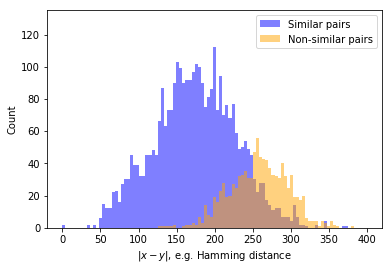

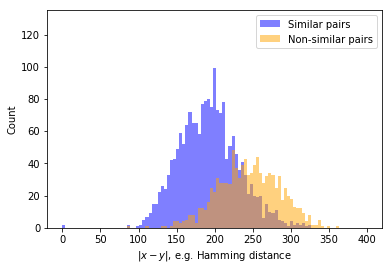

2859/2859 [==============================] - 1s 186us/step
2018-03-08 23:02:32,880 - root - DEBUG - [Iteration = 21] Training Loss = 56.60026361212329, Testing Loss = 80.26917162280101
2018-03-08 23:02:32,881 - root - DEBUG - Iteration 22 (current beta = 4987.885095119476)


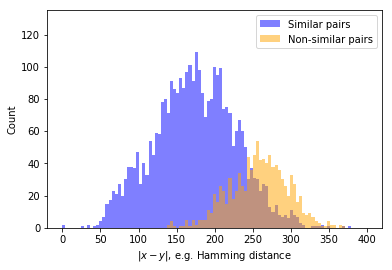

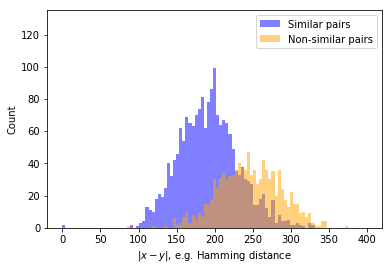

2859/2859 [==============================] - 1s 186us/step
2018-03-08 23:06:13,817 - root - DEBUG - [Iteration = 22] Training Loss = 56.41367574141585, Testing Loss = 79.46994086052413
2018-03-08 23:06:13,819 - root - DEBUG - Iteration 23 (current beta = 7481.8276426792145)


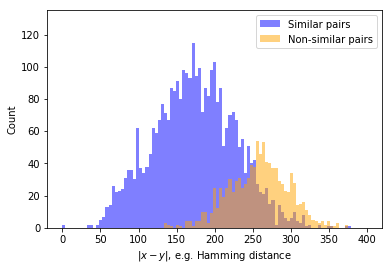

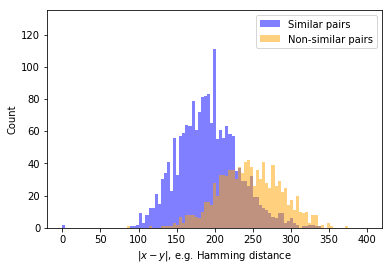

2859/2859 [==============================] - 1s 187us/step
2018-03-08 23:09:53,134 - root - DEBUG - [Iteration = 23] Training Loss = 57.75810208123908, Testing Loss = 80.21599525186139
2018-03-08 23:09:53,135 - root - DEBUG - Iteration 24 (current beta = 11222.741464018822)


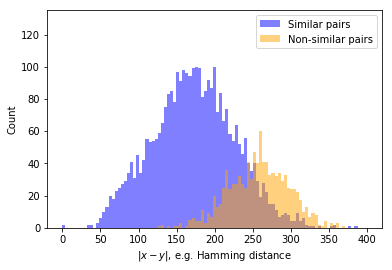

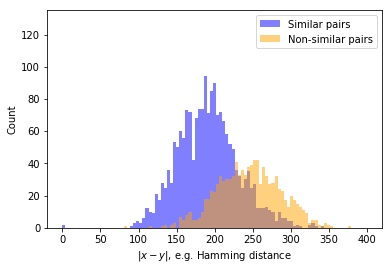

2859/2859 [==============================] - 1s 182us/step
2018-03-08 23:13:33,726 - root - DEBUG - [Iteration = 24] Training Loss = 57.95208765500473, Testing Loss = 81.09290301895675
2018-03-08 23:13:33,727 - root - DEBUG - Iteration 25 (current beta = 16834.112196028233)


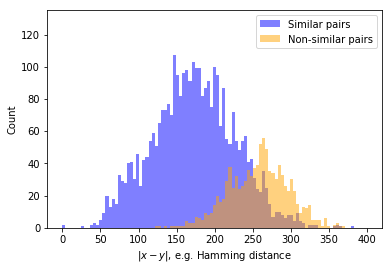

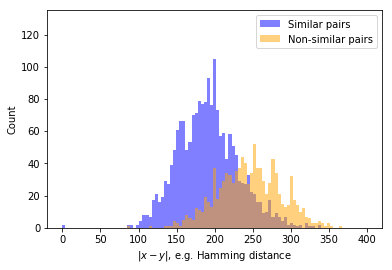

2859/2859 [==============================] - 1s 183us/step
2018-03-08 23:17:12,662 - root - DEBUG - [Iteration = 25] Training Loss = 58.032434216199995, Testing Loss = 80.22124171290376
2018-03-08 23:17:12,663 - root - DEBUG - Iteration 26 (current beta = 25251.16829404235)


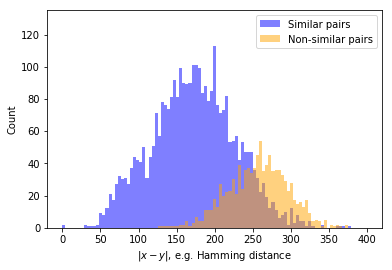

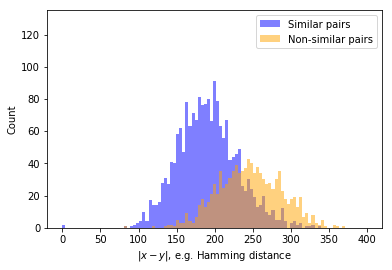

2859/2859 [==============================] - 1s 182us/step
2018-03-08 23:20:53,629 - root - DEBUG - [Iteration = 26] Training Loss = 58.89700330719035, Testing Loss = 80.34517062256577
2018-03-08 23:20:53,630 - root - DEBUG - Iteration 27 (current beta = 37876.75244106352)


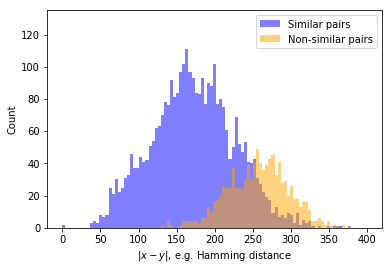

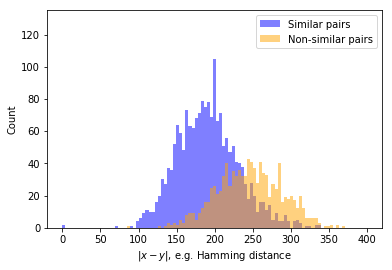

2859/2859 [==============================] - 1s 181us/step
2018-03-08 23:24:32,481 - root - DEBUG - [Iteration = 27] Training Loss = 59.77105582866542, Testing Loss = 81.33532110016094
2018-03-08 23:24:32,482 - root - DEBUG - Iteration 28 (current beta = 56815.128661595285)


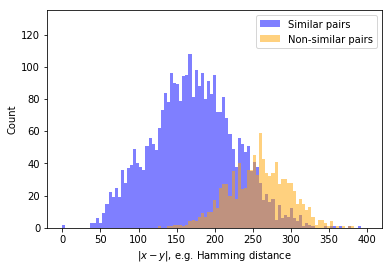

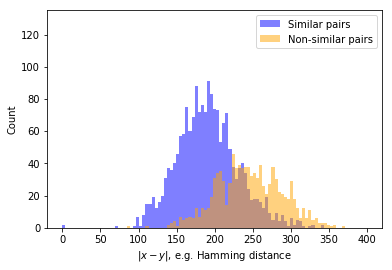

2859/2859 [==============================] - 1s 182us/step
2018-03-08 23:28:12,156 - root - DEBUG - [Iteration = 28] Training Loss = 59.8569274786541, Testing Loss = 81.8465992932388
2018-03-08 23:28:12,158 - root - DEBUG - Iteration 29 (current beta = 85222.69299239293)


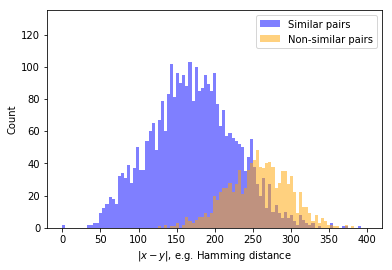

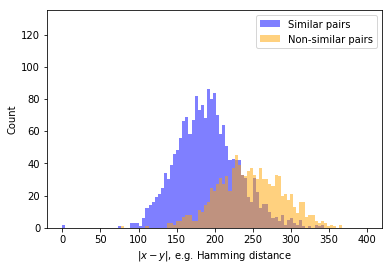

2859/2859 [==============================] - 1s 177us/step
2018-03-08 23:31:50,185 - root - DEBUG - [Iteration = 29] Training Loss = 60.69274972078556, Testing Loss = 81.49081455889845
2018-03-08 23:31:50,186 - root - DEBUG - Iteration 30 (current beta = 127834.03948858939)


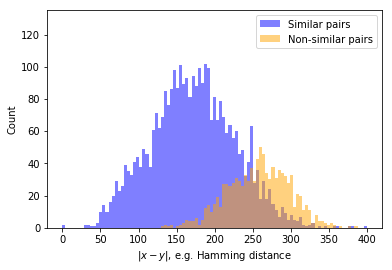

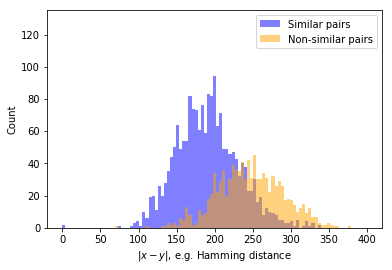

2859/2859 [==============================] - 1s 185us/step
2018-03-08 23:35:30,315 - root - DEBUG - [Iteration = 30] Training Loss = 60.72500021467528, Testing Loss = 80.94698438547674


In [35]:
train_loss = model.evaluate({'image_1': X1, 'image_2': X2, 'similarity': S, 'weight': W}, [S])
test_loss  = model.evaluate({'image_1': X1_val, 'image_2': X2_val, 'similarity': S_val, 'weight': W_val}, [S_val])
logger.debug("[Iteration = {:}] Training Loss = {:}, Testing Loss = {:}".format(0, train_loss, test_loss))
train_losses.append(train_loss)
test_losses.append(test_loss)

for m in range(1, number_of_iterations+1):
    logger.debug("Iteration {:} (current beta = {:})".format(m, beta))
    
    # Train a model with 4 inputs and 1 dummy output.
    model.fit({'image_1': X1, 'image_2': X2, 'similarity': S, 'weight': W}, [S], verbose=verbose, epochs=number_of_epochs)
    beta *= beta_factor
    
    representation_model = Model(image_a, encoded_a)
    visualize(X1, X2, groundTruth, representation_model)
    visualize(X1_val, X2_val, groundTruth_val, representation_model)
#     visualizeFilters()
    
    train_loss = model.evaluate({'image_1': X1, 'image_2': X2, 'similarity': S, 'weight': W}, [S])
    test_loss  = model.evaluate({'image_1': X1_val, 'image_2': X2_val, 'similarity': S_val, 'weight': W_val}, [S_val])
    logger.debug("[Iteration = {:}] Training Loss = {:}, Testing Loss = {:}".format(m, train_loss, test_loss))
    train_losses.append(train_loss)
    test_losses.append(test_loss)

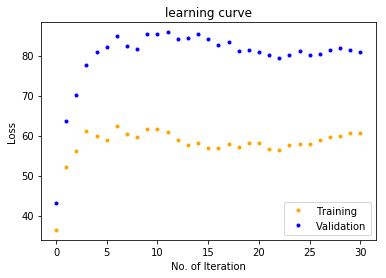

In [36]:
plt.figure()
plt.title("learning curve")
plt.plot(range(0,len(train_losses)), train_losses, '.', color='orange', label='Training')
plt.plot(range(0,len(test_losses)), test_losses, '.', color='blue', label='Validation')
plt.legend()
plt.ylabel("Loss")
plt.xlabel("No. of Iteration")
plt.show()

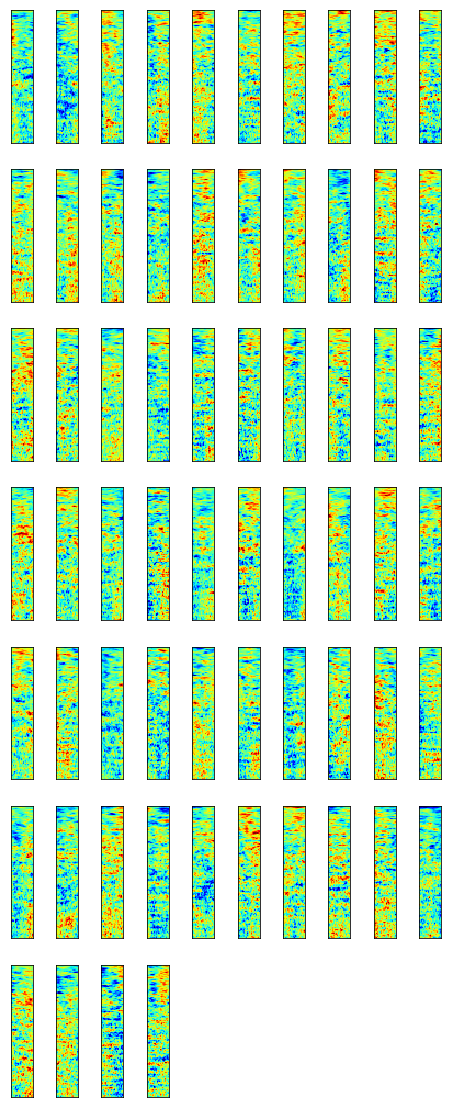

In [37]:
visualizeFilters()

## Save Model

In [38]:
MODEL_NAME = str(datetime.date.today()) + EXPERIMENT_NAME + "[Iteration={:}]".format(number_of_iterations)
logger.debug("Save model to {:}.h5".format(MODEL_NAME))
model.save(MODEL_NAME + ".h5")

2018-03-08 23:35:33,790 - root - DEBUG - Save model to 2018-03-08[HashNet-100-iteration-dropout-delta-notrain][Iteration=30].h5


## Visualize Performance 

__Obtain a representation model__

This representation model is the same as the trained model above without the loss layer at the very end.

In [39]:
representation_model = Model(image_a, encoded_a)

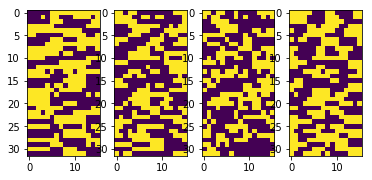

In [40]:
# Get sample output
# Reshaped to be (32,16) for visualization purposes.
pred_X1 = representation_model.predict(X1)
plt.subplot(1,4,1)
plt.imshow(pred_X1[:1].reshape(32,16) > 0)
plt.subplot(1,4,2)
plt.imshow(pred_X1[1:2].reshape(32,16) > 0)
plt.subplot(1,4,3)
plt.imshow(pred_X1[2:3].reshape(32,16) > 0)
plt.subplot(1,4,4)
plt.imshow(pred_X1[3:4].reshape(32,16) > 0)
plt.show()

## Evaluate Performance
Calculate the hamming distance input pairs and plot the corresponding histogram.

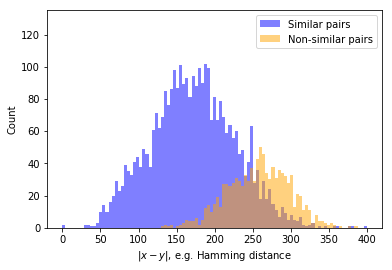

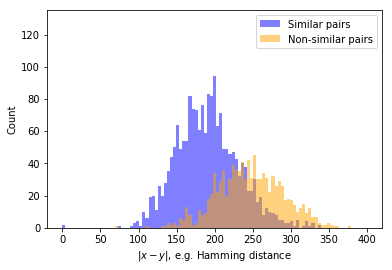

In [41]:
representation_model = Model(image_a, encoded_a)
visualize(X1, X2, groundTruth, representation_model)
visualize(X1_val, X2_val, groundTruth_val, representation_model)

## Appendix: Architecture Details

In [42]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_1 (InputLayer)            (None, 1, 76, 121)   0                                            
__________________________________________________________________________________________________
image_2 (InputLayer)            (None, 1, 76, 121)   0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 64, 8, 1)     175360      image_1[0][0]                    
                                                                 image_2[0][0]                    
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 512)          0           sequential_1[1][0]               
__________

In [43]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 12, 1)         154880    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 12, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 8, 1)          20480     
Total params: 175,360
Trainable params: 154,880
Non-trainable params: 20,480
_________________________________________________________________
